# Introduction

In this notebook, we explore how to create structured knowledge bases from a dataset. These offline processes are designed to greatly enhance online retrieval-augmented generation (RAG) applications.

We begin with the **Poetry Foundation** dataset, using a large language model (LLM) to generate embeddings from the last hidden states. These embeddings capture the semantic meanings of the poems and are managed by a **FAISS** index, enabling efficient similarity search.

We then leverage the LLM to infer keywords from each poem, identifying key concepts within the text. These keywords are used to construct a knowledge graph with **NetworkX**, providing a structured representation of relationships between poems and keywords.

By building both a vector database and a knowledge graph, this notebook reveals the thematic connections and structures within the poetry dataset. In subsequent sessions, we will integrate these knowledge bases into our multi-agent system.

In [1]:
import json
import os
import pickle
from collections import Counter

import faiss
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import spacy
import torch
from huggingface_hub import login
from tqdm.notebook import trange, tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Inspecting Data

In this notebook, we will use the [Poetry Foundation Poems](https://www.kaggle.com/datasets/tgdivy/poetry-foundation-poems/code). It contains nearly all poems from the [Poetry Foundation Website](https://www.poetryfoundation.org/). 

### Why Poetry?
```
In beauty's grasp, the verses play,
Concise in form, they light the way.
Ideal for big thoughts on small devices,
In every line, a world that entices.
```

Let's begin by examining the data.


In [2]:
# Load the .npz file with allow_pickle=True
loaded_npz = np.load('data/input/poetry_data_clean.npz', allow_pickle=True)

# Reconstruct the DataFrame using the saved data and columns
df = pd.DataFrame(loaded_npz['df'], columns=loaded_npz['columns'])

# Print the DataFrame
print(len(df))
print(df.head())

13854
  Index                               Title  \
0     0  Objects Used to Prop Open a Window   
1     1                      The New Church   
2     2                         Look for Me   
3     3                           Wild Life   
4     4                            Umbrella   

                                                Poem              Poet Tags  
0  Dog bone, stapler,\ncribbage board, garlic pre...  Michelle Menting       
1  The old cupola glinted above the clouds, shone...     Lucia Cherciu       
2  Look for me under the hood\nof that old Chevro...        Ted Kooser       
3  Behind the silo, the Mother Rabbit\nhunches li...   Grace Cavalieri       
4  When I push your button\nyou fly off the handl...      Connie Wanek       


In [3]:
def format_poems(idx, include_tags=False):
    """ format poems """
    if hasattr(idx, "__len__"):
        return [format_poems(i_, include_tags) for i_ in idx]
    it = df.iloc[idx]
    res = f'{it["Title"]}\n{it["Poet"]}\n\n{it["Poem"]}'
    if it["Tags"] and include_tags:
        res += f'\n\nNotes: {it["Tags"]}'
    return res


print(format_poems(99, include_tags=True))

Lucky Duck
Sandra Lim

Be large with those small fears. The whole sky
has fallen on you and all you can do about it is
shout, dragging your fear-ettes by their pinked ears.
 
They dance a number now: consequence without
sequence. Lovingly broadminded in their
realization and ruin, expert at the parting shot.
 
Not so small after all, we micro to
macro, swelling to the horror shows
lifted from the sly ways of life.
 
You, both scorched and shining in the terror
of the equivocal moment, its box of cheeky
logics rattling cold certainties out of bounds
 
and into the plaits of a girl’s desirous ends.
A little debauched, the flirt in a freckling,
wondering spun to falling comes to this
 
pert contract of a paradox: saying things
because they will do no good, ringing change
in frumpy mono-determination, fruity and fruitless.
 
Exploded out of shelter, the tides come roaring in.
Let in the hoarse Cassandras and the dull pain of the
storyteller. You’ve needed those eyes all along.
 
We thought

# Vector Database

In this section, we will prepare a vector database using **FAISS**, a library designed for efficient similarity search and clustering of dense vectors. 

### Deep Embeddings
To leverage fast and scalable vector-based algorithms for retrieval-augmented generation (RAG), the data must first be encoded into real-valued vectors. This can be achieved by passing the text through an LLM and using the output from the last hidden layer as the embeddings. 

**Why use the whole transformer?** 
Using the entire transformer allows us to capture the contextual information that may be critical for understanding the semantics of the text. The **deep embeddings** generated from the last hidden layer are enriched with this context, making them more effective for similarity searches.

First, let's load our tokenizer and model.


In [4]:
# Read HF_ACCESS_KEY into hf_access_key
with open("api_keys.json", "r") as file:
    hf_access_key = json.load(file).get("HF_ACCESS_KEY")

# Login to HuggingFace
login(hf_access_key)

# Create a BitsAndBytesConfig for 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Change this to `False` to disable quantization
    bnb_4bit_use_double_quant=True,  # Optional for performance
    bnb_4bit_quant_type='nf4',  # Normal floating-point 4-bit quantization
    bnb_4bit_compute_dtype=torch.float16  # Set compute dtype to float16 for faster inference
)

# Model name--you can change to many huggingface models
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto",
    quantization_config=quantization_config
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Next, we compute the deep embeddings. 

Embedding computation for the entire dataset may take up to **an hour on an A100 GPU**.
To save time or if you don't have access to a powerful GPU, we provide a pre-generated vector database that allows you to skip the embedding process entirely using the following flag.

In [5]:
SKIP_MASSIVE_COMPUTATION = True

In [6]:
if not SKIP_MASSIVE_COMPUTATION:
    # List to store the embeddings for each text
    embeddings_list = []

    # Loop through the texts and display a progress bar using tqdm.notebook.trange
    for i in trange(len(df), desc="Embedding Texts"):
        # Tokenize the individual text (convert text to token IDs, apply padding)
        inputs = tokenizer([format_poems(i)], return_tensors="pt", padding=True)

        # Pass input through the model with output_hidden_states=True
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Extract the hidden states from the output (last hidden state layer)
        hidden_states = outputs.hidden_states[-1]  # Shape: [batch_size, seq_length, hidden_size]

        # Get the attention mask (1 for real tokens, 0 for padding)
        attention_mask = inputs['attention_mask'].unsqueeze(-1).expand(
            hidden_states.size())  # Shape: [batch_size, seq_length, hidden_size]

        # Apply the mask to zero out the padding token embeddings
        masked_hidden_states = hidden_states * attention_mask  # Shape: [batch_size, seq_length, hidden_size]

        # Compute the sum of the embeddings for non-padding tokens
        sum_embeddings = masked_hidden_states.sum(dim=1)  # Sum over the sequence dimension

        # Compute the number of non-padding tokens for each sentence
        non_pad_tokens = attention_mask.sum(dim=1)  # Shape: [batch_size, hidden_size]

        # Perform mean pooling by dividing the sum by the number of non-padding tokens
        embedding = sum_embeddings / non_pad_tokens.clamp(min=1e-9)  # Avoid division by zero

        # Append the embedding to the list
        embeddings_list.append(embedding)

    # Concatenate all the embeddings into a single tensor
    deep_embeddings = torch.cat(embeddings_list, dim=0).cpu()

    # Save results
    torch.save(deep_embeddings, 'data/knowledge_bases/poetry_embeddings.pt')

else:
    # Download pre-generated
    # Google Drive file link and output path
    google_drive_link = "https://drive.google.com/uc?id=18z1pVoJbl66gB7HdkXxa7-UOzi99y764"  # noqa
    output_path = 'data/knowledge_bases/poetry_embeddings.pt'

    # Check if the file already exists before downloading
    if not os.path.exists(output_path):
        print(f"File not found locally. Downloading from Google Drive to {output_path}...")
        gdown.download(google_drive_link, output_path, quiet=False)
    else:
        print(f"File already exists at {output_path}. Skipping download.")

    # Load the embeddings after download or if already present
    deep_embeddings = torch.load(output_path, weights_only=True)

# Change to numpy
deep_embeddings = deep_embeddings.numpy()
print("Embedding shape:", deep_embeddings.shape)

File already exists at data/knowledge_bases/poetry_embeddings.pt. Skipping download.
Embedding shape: (13854, 4096)


### FAISS Index

Now we create the FAISS index. There are many different methods we can use, and typical ones are listed below:


| Name          | Speed (1-5) | Memory (1-5) | Accuracy (1-5) | ANN* (Yes/No) | Description                                                                      |
|---------------|-------------|--------------|----------------|---------------|----------------------------------------------------------------------------------|
| IndexFlatL2   | 2           | 5            | 5              | No            | Direct computation of distances; exact nearest neighbor search.                  |
| IndexIVFFlat  | 4           | 3            | 3              | Yes           | Uses inverted file indexing to search within clusters, improving speed.          |
| IndexIVFPQ    | 5           | 2            | 3              | Yes           | Combines IVF with product quantization for fast and memory-efficient search.     |
| IndexHNSWFlat | 5           | 4            | 4              | Yes           | Utilizes a hierarchical navigable small world graph for efficient searching.     |
| IndexLSH      | 5           | 2            | 2              | Yes           | Employs locality-sensitive hashing for fast approximate nearest neighbor search. |

* **ANN** stands for **Approximate Nearest Neighbor**. This refers to algorithms that find points in a high-dimensional space that are close to a given query point but do not guarantee exact matches. ANN methods trade off some accuracy for improved speed and efficiency, making them suitable for large datasets.

In [7]:
# Create the HNSW FAISS index
embedding_dim = deep_embeddings.shape[1]  # Dimension of your embeddings
num_neighbors = 32  # Number of connections (neighbors) for each node
index = faiss.IndexHNSWFlat(embedding_dim, num_neighbors)

# Add embeddings to the index
index.add(deep_embeddings)

# Save index to file
faiss.write_index(index, "data/knowledge_bases/poetry_faiss.index")

Perform a search.

In [8]:
# Search for the nearest neighbors of the first embedding
query_embedding = deep_embeddings[0:1]

# k is number of nearest neighbors to retrieve
distances, indices = index.search(query_embedding, k=5)

# Step 4: Display the results
print("Nearest neighbors (indices):", indices)
print("Distances to the nearest neighbors:", distances)

Nearest neighbors (indices): [[    0  8151 10893 11236  2797]]
Distances to the nearest neighbors: [[   0.     1858.0122 2073.8438 2088.0269 2114.9927]]


# Knowledge Graph

In addition to the FAISS index, we will also create a keyword-based knowledge graph using **NetworkX**, a powerful graph database management system.
 
First, we identify up to ten keywords for each poem to serve as "nodes" in a bipartite graph, where keyword nodes connect to corresponding poem nodes. This knowledge graph enables rapid keyword-based retrieval and supports **associative retrieval**, broadening the scope of search possibilities.


### Keyword Identification

We will utilize our LLM to identify keywords through natural language prompts. Additionally, traditional NLP methods such as TF-IDF and RAKE can be employed for this task. While these methods are generally more efficient, they may lack the deeper comprehension needed to uncover nuanced themes, especially those in poems.

**Prompts** are crucial for the quality of LLM-based reasoning. In this example, our prompt provides clear instructions along with an example to outline the **goal, requirements, and output format**. For example, the presence of the `[` character at the end is key to achieving a stable format, leveraging the autoregressive nature of the model.

In [9]:
# Prompt template
prompt_template = ("Identify or infer up to 10 semantically meaningful keywords from the following poem. " +
                   "The keywords should be commonly used nouns or verbs. " +
                   "Provide the keywords directly after `YOUR ANSWER:`, formatted within brackets and separated by commas, such as " +
                   "YOUR ANSWER: [teacher, classroom].\n" +
                   "\n\n%s\n\n%s\n\n\n" +
                   "YOUR ANSWER: [")

# A prompt example
print(prompt_template % ("POEM TITLE", "POEM BODY"))

Identify or infer up to 10 semantically meaningful keywords from the following poem. The keywords should be commonly used nouns or verbs. Provide the keywords directly after `YOUR ANSWER:`, formatted within brackets and separated by commas, such as YOUR ANSWER: [teacher, classroom].


POEM TITLE

POEM BODY


YOUR ANSWER: [


Again, this process is computationally expensive and may take up to **five hours on an A100 GPU**. Therefore, we provide a pre-generated version available for download (already in repository).

In [10]:
if not SKIP_MASSIVE_COMPUTATION:
    # List to store the keywords for each text
    keywords_list = []

    # Loop through the texts and display a progress bar using tqdm.notebook.trange
    pbar = trange(len(df), desc="Extracting Keywords")
    for i in pbar:
        # Create a prompt
        prompt = prompt_template % (df.iloc[i]['Title'], df.iloc[i]['Poem'])

        # Encode the prompt
        inputs = tokenizer(prompt, return_tensors="pt")

        # Generate output
        with torch.no_grad():
            outputs = model.generate(inputs['input_ids'].cuda(),
                                     max_new_tokens=25, temperature=0.1,
                                     attention_mask=inputs['attention_mask'],
                                     pad_token_id=tokenizer.eos_token_id)

        # Contents after "ANSWER:"
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True).split("YOUR ANSWER:")[-1].strip()

        # Parsing results
        first_left_index = generated_text.find("[")
        first_right_index = generated_text.find("]")
        keywords_text = generated_text[first_left_index + 1:first_right_index]
        keywords = [keyword.strip() for keyword in keywords_text.split(",") if keyword.strip()]

        # Store in results
        keywords_list.append(keywords)
        pbar.set_postfix(keywords=str(keywords))

    # Save keywords_list to a pickle file
    with open('data/knowledge_bases/poetry_keywords.pkl', 'wb') as f:
        pickle.dump(keywords_list, f)
else:
    # Load the keywords after download or if already present
    with open('data/knowledge_bases/poetry_keywords.pkl', 'rb') as f:
        keywords_list = pickle.load(f)

Next, we will parse the results using **spaCy**, a powerful tool for performing fine-scale NLP tasks.

1. Retain only the nouns and verbs.
2. Convert them to their lemmatized form (e.g., `eggs` to `egg`, and `ran` to `run`).

In [11]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# List to store the cleaned keywords
cleaned_keywords_list = []

# Process each list of keywords individually
for keywords in tqdm(keywords_list, "Parsing keywords"):
    filtered_keywords = []
    for keyword in keywords:
        # Process each keyword individually
        doc = nlp(keyword)
        if doc[0].pos_ in ['NOUN', 'PROPN', 'VERB']:  # filter
            filtered_keywords.append(doc[0].lemma_)  # lemmatize

    # Append the cleaned keywords to the list
    cleaned_keywords_list.append(filtered_keywords)

# Output the cleaned keywords
for i in range(5):
    print("Before:", keywords_list[i])
    print("After: ", cleaned_keywords_list[i])
    print("-------")

Parsing keywords:   0%|          | 0/13854 [00:00<?, ?it/s]

Before: ['window', 'bone', 'board', 'press', 'cord', 'belt', 'glue', 'blanket', 'wing', 'frame']
After:  ['window', 'bone', 'board', 'press', 'cord', 'belt', 'glue', 'blanket', 'wing', 'frame']
-------
Before: ['church', 'hill', 'village', 'road', 'house', 'trees', 'clouds', 'stick', 'mass', 'moon']
After:  ['church', 'hill', 'village', 'road', 'house', 'tree', 'cloud', 'stick', 'mass', 'moon']
-------
Before: ['Chevrolet', 'pasture', 'engine', 'wind', 'moths', 'grasshoppers', 'names', 'forgotten']
After:  ['chevrolet', 'pasture', 'engine', 'wind', 'moth', 'grasshopper', 'name', 'forget']
-------
Before: ['wildlife', 'rabbit', 'mother', 'babies', 'milk', 'syringe', 'pulpit', 'sand', 'turret', 'emotions', 'underbrus']
After:  ['wildlife', 'rabbit', 'mother', 'baby', 'milk', 'syringe', 'pulpit', 'sand', 'turret', 'emotion', 'underbrus']
-------
Before: ['umbrella', 'button', 'handle', 'skin', 'bones', 'bat', 'wing', 'mother', 'advocacy', 'child', 'death', 'wind']
After:  ['umbrella', 'bu

Next, we will determine a set of unique keywords and establish the forward and inverse mappings:

* **Forward Mapping**: Maps poems to their corresponding keywords.
* **Inverse Mapping**: Maps keywords to the poems in which they appear.

These mappings can facilitate our future tasks.

In [12]:
# Flatten the cleaned keywords and get unique keywords
flattened_keywords = [kw for sublist in cleaned_keywords_list for kw in sublist]
unique_keywords_list = list(set(flattened_keywords))

# Create a mapping from keyword to its index for O(1) lookups
keyword_to_index = {kw: idx for idx, kw in enumerate(unique_keywords_list)}

# Initialize inverse mapping
inverse_mapping = [[] for _ in range(len(unique_keywords_list))]

# Initialize forward mapping with the same structure as inverse_mapping
forward_mapping = [[] for _ in range(len(cleaned_keywords_list))]

# Create forward and inverse mappings in one loop
for poem_index, keywords in enumerate(cleaned_keywords_list):
    for kw in keywords:
        if kw in keyword_to_index:  # Check if the keyword exists in the mapping
            keyword_index = keyword_to_index[kw]
            forward_mapping[poem_index].append(keyword_index)  # Pop forward mapping
            inverse_mapping[keyword_index].append(poem_index)  # Pop inverse mapping

# Output the results
print("Number of Unique Keywords:", len(unique_keywords_list))
print("Unique Keywords List:", unique_keywords_list[:3])
print("Forward Mapping:", forward_mapping[:3])
print("Inverse Mapping:", inverse_mapping[:3])

# Save the results
with open('data/knowledge_bases/poetry_unique_keywords.pkl', 'wb') as f:
    pickle.dump(unique_keywords_list, f)
with open('data/knowledge_bases/poetry_forward_mapping.pkl', 'wb') as f:
    pickle.dump(forward_mapping, f)
with open('data/knowledge_bases/poetry_inverse_mapping.pkl', 'wb') as f:
    pickle.dump(inverse_mapping, f)

Number of Unique Keywords: 11009
Unique Keywords List: ['Amyntas', 'sash', 'killin']
Forward Mapping: [[9435, 3095, 5531, 10788, 386, 842, 910, 7918, 7153, 9247], [8652, 329, 6304, 8834, 5161, 5365, 2969, 3086, 9910, 10059], [10431, 9915, 2128, 6697, 5089, 2828, 6468, 2983]]
Inverse Mapping: [[7326], [6099, 10133, 13339], [6109]]


### Graph Creation

We can now create a **bipartite graph** using NetworkX, consisting of two types of nodes:

* **Poem Nodes**: Each node represents a poem.
* **Keyword Nodes**: Each node represents a keyword.

An edge connects a poem node to a keyword node if the keyword is one of the poem’s associated keywords.


In [13]:
# Create a graph (pk means poem-keyword bipartite graph)
pk_graph = nx.Graph()

# Add nodes for each unique keyword
pk_graph.add_nodes_from(unique_keywords_list)

# Add nodes for each poem
num_poems = len(forward_mapping)
pk_graph.add_nodes_from(list(range(num_poems)))

# Add edges
for i in range(num_poems):
    for j in forward_mapping[i]:
        pk_graph.add_edge(i, unique_keywords_list[j])

# Save the graph
with open("data/knowledge_bases/poetry_keyword_graph.gpickle", "wb") as f:
    pickle.dump(pk_graph, f)

Let's visualize the top K nodes of the graph.

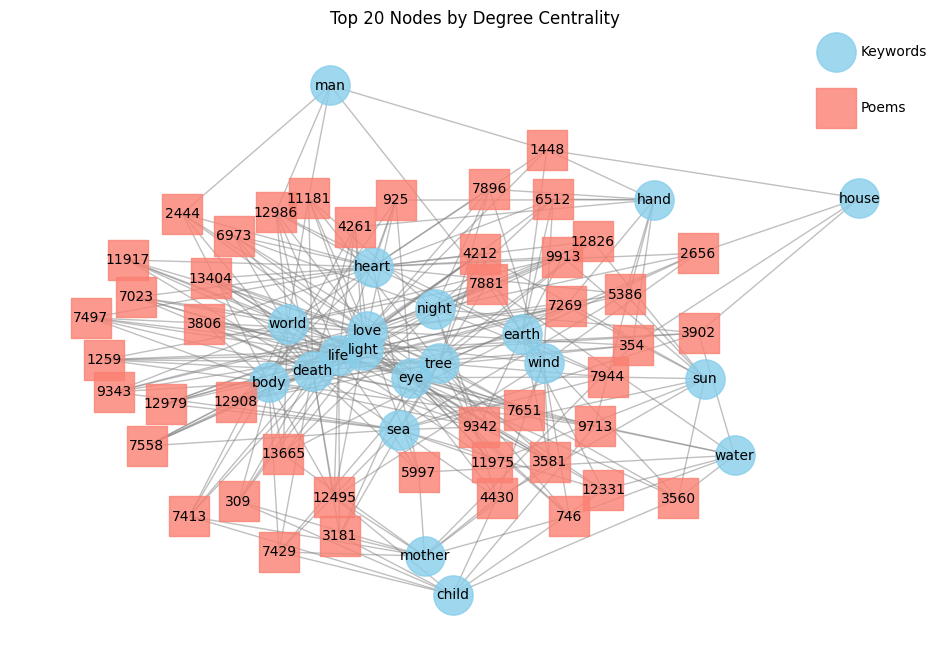

In [14]:
# How many keyword nodes to visualize
n_keyword_nodes = 20

# Compute degree centrality of graph
degree_centrality = nx.degree_centrality(pk_graph)

# Sort keyword nodes by centrality and take the top K
top_keyword_nodes = [node for node, _ in
                     sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:n_keyword_nodes]]

# Track connections of poem nodes to keyword nodes
poem_connections = Counter()

# Find all poem nodes connected to these top keywords
for kw_node in top_keyword_nodes:
    for poem_node in pk_graph.neighbors(kw_node):
        poem_connections[poem_node] += 1

# Select poem nodes that connect to at least two of the top keyword nodes
connected_poem_nodes = {node for node, count in poem_connections.items() if count >= 6}

# Create a subgraph with only the top nodes and their edges
subgraph = pk_graph.subgraph(top_keyword_nodes + list(connected_poem_nodes))

# Create a layout for the subgraph
pos = nx.spring_layout(subgraph)

# Draw the subgraph with different styles for keyword and poem nodes
plt.figure(figsize=(12, 8))

# Draw keyword nodes in a different color and shape (e.g., circles)
nx.draw_networkx_nodes(subgraph, pos, nodelist=[node for node in top_keyword_nodes if node in subgraph],
                       node_size=800, node_color='skyblue', node_shape='o', alpha=0.8, label="Keywords")

# Draw poem nodes in a different color and shape (e.g., squares)
nx.draw_networkx_nodes(subgraph, pos, nodelist=[node for node in connected_poem_nodes if node in subgraph],
                       node_size=800, node_color='salmon', node_shape='s', alpha=0.8, label="Poems")

# Draw edges and labels
nx.draw_networkx_edges(subgraph, pos, width=1, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=10)

# Add title and legend
plt.title(f"Top {n_keyword_nodes} Nodes by Degree Centrality")
plt.legend(scatterpoints=1, labelspacing=3, frameon=False)
plt.axis('off')
plt.show()

Finally, let's perform some tasks.

In [15]:
# Counting the Number of Steps Between a Poem and a Keyword
keyword = "sunset"
poem_node = 5  # Suppose poem index 5 is a specific poem node
try:
    distance = nx.shortest_path_length(pk_graph, source=keyword, target=poem_node)
    print(f"\nThe distance between '{keyword}' and poem {poem_node} is {distance} steps.")
except nx.NetworkXNoPath:
    print(f"\nNo path found between '{keyword}' and poem {poem_node}.")

# Getting All Keywords within a Certain Path Depth from a Poem
poem_node = 3  # Suppose poem index 3 is a specific poem
path_depth = 2
related_keywords = nx.single_source_shortest_path_length(pk_graph, poem_node, cutoff=path_depth)

# Filter out only keyword nodes
related_keywords = {node: dist for node, dist in related_keywords.items() if node in unique_keywords_list}

print(f"\nKeywords within {path_depth} steps of poem {poem_node}: {related_keywords}")

# Finding the Degree of Centrality for Each Keyword Node
centrality = nx.degree_centrality(pk_graph)
top_keywords = sorted([(node, cent) for node, cent in centrality.items() if node in unique_keywords_list],
                      key=lambda x: x[1], reverse=True)

print("\nTop keywords by centrality:")
for keyword, score in top_keywords[:10]:  # Display the top 10 keywords
    print(f"Keyword: {keyword}, Centrality Score: {score}")


The distance between 'sunset' and poem 5 is 3 steps.

Keywords within 2 steps of poem 3: {'wildlife': 1, 'rabbit': 1, 'mother': 1, 'baby': 1, 'milk': 1, 'syringe': 1, 'pulpit': 1, 'sand': 1, 'turret': 1, 'emotion': 1, 'underbrus': 1}

Top keywords by centrality:
Keyword: love, Centrality Score: 0.06435524092993324
Keyword: night, Centrality Score: 0.04886976108116805
Keyword: heart, Centrality Score: 0.04850776285093717
Keyword: death, Centrality Score: 0.04516933472769689
Keyword: tree, Centrality Score: 0.04343978762770493
Keyword: life, Centrality Score: 0.04339956560212372
Keyword: water, Centrality Score: 0.04058402381143914
Keyword: light, Centrality Score: 0.04022202558120827
Keyword: eye, Centrality Score: 0.03945780709516531
Keyword: world, Centrality Score: 0.03901536481377202


# More Exercises

- **Utilize Shallow Embedding**: Build a vector database using **shallow embeddings** derived from the output of the embedding layer (e.g., `model.base_model.embed_tokens` for Llama 3). Shallow embeddings are faster to compute as they involve only a single layer. Reflect on why deep embeddings, despite requiring more computation, may still be preferred in some applications.

- **Explore FAISS Index Types**: Investigate the various index types available in FAISS, examining their trade-offs in terms of speed, memory usage, and accuracy. Evaluate which index types may be best suited for different retrieval scenarios.

- **Implement Traditional NLP Methods for Keyword Extraction**: Apply traditional NLP methods, such as TF-IDF and RAKE, to extract keywords. Compare these results with those generated by the LLM to understand the strengths and limitations of each approach in terms of effectiveness and efficiency.

- **Add Edges Between Poems Based on Deep Embedding Similarity**: Consider adding edges between poems that are similar based on their deep embeddings. This could enhance retrieval by connecting works with thematic or stylistic similarities.

- **Add Poet Names as Nodes**: Introduce poet names as additional nodes, connecting each poet to their respective works. Explore how this setup could enable retrieval based on authorship and potentially similar styles or themes among poets.

